In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, expon

## Sanity test

This notebook is for sanity test of the proof of https://github.com/chengsoonong/eheye/tree/master/writing/QuantUCB_orderstat

##### Test left tail of Berstein inequality 

In Proposition 3, $P\left( \mathbb{E}[ X_{(n/2)}] - X_{(n/2)} \geq \sqrt{2v_n \varepsilon} + 2 \varepsilon \sqrt{v_n/n} \right) \leq P\left( X_{(n/2)}-\mathbb{E}[ X_{(n/2)}] \geq \sqrt{2v_n \varepsilon} + 2 \varepsilon \sqrt{v_n/n} \right) \leq e^{-\varepsilon}$, where $X_{(n/2)}$ is the sample median of the abosulte centered normal distribution with the variance $\sigma^2$, $v_n = 8/(n \sigma^2log2)$, $\varepsilon = 4 logn$, the expectation is in terms of different experiments.

The experiment is designed to test whether the inequality holds for different n. We set n = 10, 100, 1000, 10000. The number of experiments is set to be 1000.

when n =  10
mean_of_median:  0.6614673530204362
bound: [ -10.207460541590587 11.530395247631459 ]


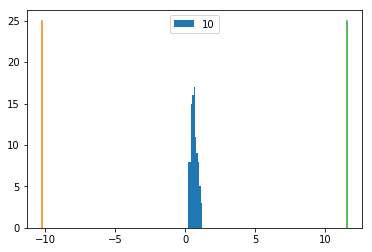

when n =  100
mean_of_median:  0.6826240943089898
bound: [ -2.6310370703862054 3.9962852590041846 ]


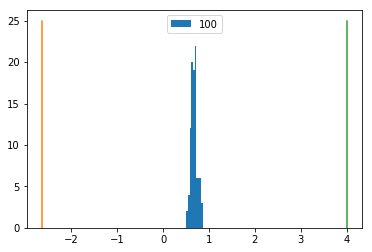

when n =  1000
mean_of_median:  0.6754701719496132
bound: [ -0.31090105549837155 1.661841399397598 ]


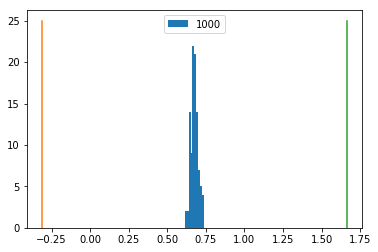

when n =  10000
mean_of_median:  0.6737587938226849
bound: [ 0.3571081400427106 0.9904094476026593 ]


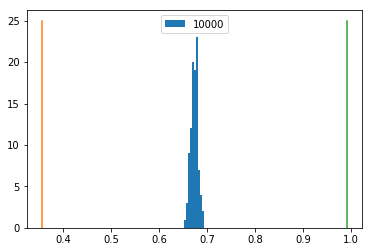

In [49]:
num_exper = 100
sigma = 1.0

n = [10, 100, 1000, 10000]

for j in n:
    print('when n = ', j)
    medians = []
    for i in range(num_exper):
        medians.append(np.median(np.abs(np.random.normal(0, sigma, size = j))))
    mean_of_median = np.mean(medians)
    print('mean_of_median: ', mean_of_median)
    vn = 8.0/ (j * (sigma**2) * np.log(2))
    varep = 4 * np.log(j)
    bound = np.sqrt(2 * vn * varep) + 2 * varep * np.sqrt(vn/j)
    print('bound: [', mean_of_median - bound, mean_of_median + bound, ']')
    plt.hist(medians, label = str(j))
    plt.plot([mean_of_median - bound, mean_of_median - bound], [0, 25])
    plt.plot([mean_of_median + bound, mean_of_median + bound], [0, 25])
    plt.legend() 
    plt.show()
    p_left_tail = len(np.asarray(medians)[np.asarray(mean_of_median  - medians >= bound)])/num_exper
    p_right_tail = len(np.asarray(medians)[np.asarray(medians - mean_of_median >= bound)])/num_exper
    assert p_left_tail <= p_right_tail <= np.exp(- varep)


We show the histogram of the medians of totoally 100 experiments when n = 10, 100, 1000, 10000 respectively. The bound of medians are shown in the plots as orange and green lines. We can see that the medians are loosely bounded for all situations, even if n is small. 

##### Test the lower bound of hazard rate

For normal distribution, in Proposition 2, $\phi(\tilde{U}(\exp (y))) / \overline{\Phi}(\tilde{U}(\exp (y))) \geq \sigma \sqrt{\kappa_{1}(y+\log 2)}$, where $\widetilde{U}(t)=\Phi^{-1}(1-1 /(2 t)), \phi, \Phi$ are pdf, cdf of standard normal distribution, y are sample from standard exponential distribution.

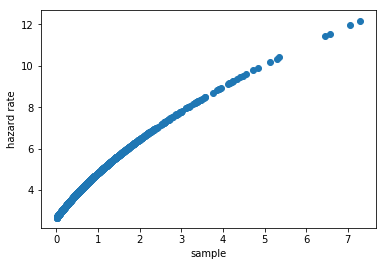

In [77]:
num_samples = 1000
sigma = 0.3
k = 0.5
hazard_list = [] 
samples = []

def u_transform(t):
    return norm.ppf(1.0-1.0/(2*t), scale = sigma)
    

for i in range(num_samples):
    sample = np.random.exponential()
    hazard_rate = norm.pdf(u_transform(np.exp(sample)), scale = sigma)/(1- norm.cdf(u_transform(np.exp(sample)), scale = sigma))
    bound = 1.0/sigma * np.sqrt(k * (sample + np.log(2)))
    hazard_list.append(hazard_rate)
    samples.append(sample)
    #print('hazard rate: ', hazard_rate)
    #print('bound: ', bound)
    assert hazard_rate >= bound
    
plt.scatter(samples, hazard_list)
plt.xlabel('sample')
plt.ylabel('hazard rate')

similarly, for exponential distribution: verfy $\frac{f(U(\exp{y}))}{\bar{F}(U(\exp{y}))} = \theta$

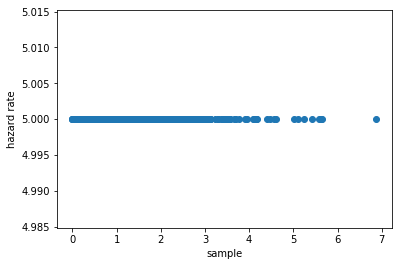

In [85]:
theta = 5

hazard_list = [] 
samples = []


def u_transform(t):
    return expon.ppf(1.0-1.0/(2*t), scale = 1.0/theta)
    

for i in range(num_samples):
    sample = np.random.exponential()
    hazard_rate = expon.pdf(u_transform(np.exp(sample)), scale = 1.0/theta)/(1- expon.cdf(u_transform(np.exp(sample)), scale = 1.0/theta))
    bound = theta
    hazard_list.append(hazard_rate)
    samples.append(sample)
    #print('hazard rate: ', hazard_rate)
    #print('bound: ', bound)
    #assert hazard_rate >= bound
    
plt.clf()
plt.scatter(samples, hazard_list)
plt.xlabel('sample')
plt.ylabel('hazard rate')

### Test for policies

[Experiment](https://github.com/chengsoonong/eheye/blob/master/QuantUCB/ucb_order_statistics.ipynb) shows for the exponential distribution, the estimated variance and true variance give quite similar regret. 

We deisgn a test policy: choose one arm A with probility p, choose other arms uniformly with probability (1-p).

Exp1: Set p = 0.8, A = the best arm. We expect at the beginning, the test policy has less regret. After n_1 rounds, the regret of test policy should cross both the UCB_OS policy regret and the corresponding regret bound. 

In [3]:
import pickle 
import numpy as np
with open('os_saving.pickle', 'rb') as handle:
    saving = pickle.load(handle)
saving

{'normal_est': array([   2.32187534,    2.96988808,    4.04969256, ..., 1986.47125085,
        1986.47125085, 1986.49825912]),
 'normal_true': array([2.02484628e+00, 2.70005307e+00, 2.70005307e+00, ...,
        3.52262804e+03, 3.52266855e+03, 3.52269556e+03]),
 'exp_est': array([  1.91695927,   2.54173647,   3.12507286, ..., 845.2065633 ,
        845.2065633 , 845.2065633 ]),
 'exp_true': array([  1.62037884,   1.63432432,   2.31765271, ..., 837.55109002,
        837.55109002, 837.55109002])}

In [2]:
class Exp_Environment():
    """Environment for distribution reward of arms.
    """
    def __init__(self, scale=1.0, size = None):  
        self.scale = scale
        self.size = size
        
    def sample(self):
        # f = 1/scale exp(-x/scale)
        return np.random.exponential(self.scale, self.size)

num_rounds = 50000
num_exper = 50

num_arms = 3
scales = [1, 2, 2.0/3] # lambda = 1, 0.5, 1.5
rewards_env = []
medians = []

for i in range(num_arms):
    rewards_env.append(Exp_Environment(scale = scales[i]))
    medians.append(np.median(np.random.exponential(scale = scales[i], size = num_rounds)))
    
print('medians are: ', medians)

best_arm = np.argmax(medians)
best_arm

medians are:  [0.6890356003563469, 1.3858769901418821, 0.46027647314616965]


1

In [20]:
from UCB_discrete import test_policy

p = 0.9
A = best_arm

regrets = []

for i in range(num_exper):
    agent = test_policy(rewards_env, num_rounds, medians, p, A)
    regrets.append(agent.play())
    
np.asarray(regrets).reshape((num_exper, num_rounds-3))
expected_regrets_test_policy = np.mean(regrets, axis = 0)

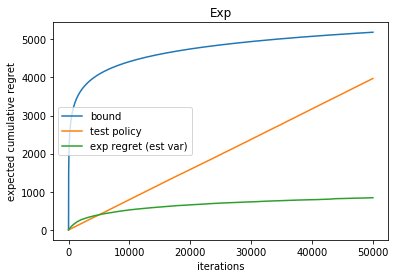

In [21]:
plt.plot(bounds, label = 'bound')
plt.plot(expected_regrets_test_policy, label = 'test policy')
plt.plot(saving['exp_est'], label = 'exp regret (est var)')
plt.xlabel('iterations')
plt.ylabel('expected cumulative regret')
plt.title('Exp')
plt.legend()

In [22]:
def bound(num_arm, num_round, medians):
    bound = 0
    best_arm = np.argmax(medians)
    for i in range(num_arm):
        theta = 1.0/scales[i]
        delta = medians[best_arm] - medians[i]
        beta = 32 * np.log(num_round) * (1 + delta * theta)
        if i != best_arm:
            bound += (np.sqrt(beta) + 4 * np.sqrt(2 * np.log(num_round)))**2/ (delta**2 * theta ** 2)
        bound+= (1+ np.pi**2/3) * delta
    return bound
        
bounds = []
for i in range(1, num_rounds):
    bounds.append(bound(num_arms, i, medians))

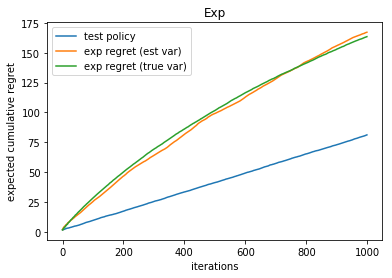

In [24]:
#plt.plot(bounds[:1000], label = 'bound')
plt.plot(expected_regrets_test_policy[:1000], label = 'test policy')
plt.plot(saving['exp_est'][:1000], label = 'exp regret (est var)')
plt.plot(saving['exp_true'][:1000], label = 'exp regret (true var)')
plt.xlabel('iterations')
plt.ylabel('expected cumulative regret')
plt.title('Exp')
plt.legend()

Exp2: Set p = 0.8, A = the worse arm. We expect at the beginning, the test policy has less regret. After n_2 rounds, the regret of test policy should cross both the UCB_OS policy regret and the corresponding regret bound. And we expect n_2 < n_1.

In [25]:
from UCB_discrete import test_policy

p = 0.9
A = np.argmin(medians)

regrets = []

for i in range(num_exper):
    agent = test_policy(rewards_env, num_rounds, medians, p, A)
    regrets.append(agent.play())
    
np.asarray(regrets).reshape((num_exper, num_rounds-3))
expected_regrets_test_policy = np.mean(regrets, axis = 0)

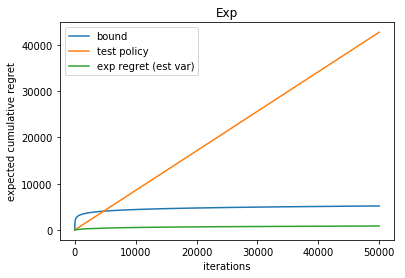

In [26]:
plt.plot(bounds, label = 'bound')
plt.plot(expected_regrets_test_policy, label = 'test policy')
plt.plot(saving['exp_est'], label = 'exp regret (est var)')
plt.xlabel('iterations')
plt.ylabel('expected cumulative regret')
plt.title('Exp')
plt.legend()

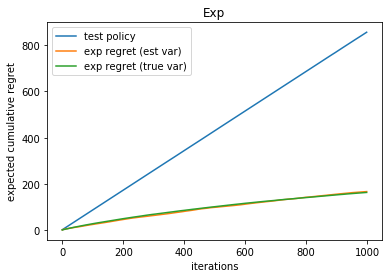

In [27]:
# only plot for first 1000 iterations

#plt.plot(bounds[:1000], label = 'bound')
plt.plot(expected_regrets_test_policy[:1000], label = 'test policy')
plt.plot(saving['exp_est'][:1000], label = 'exp regret (est var)')
plt.plot(saving['exp_true'][:1000], label = 'exp regret (true var)')
plt.xlabel('iterations')
plt.ylabel('expected cumulative regret')
plt.title('Exp')
plt.legend()

### Performace Comparison

Compare the regret of our algorithm and the UCB1. 

UCB1 is designed for mean rather than median, here we use the policy for UCB1 but evaluate by medians. 

In [4]:
from UCB_discrete import UCB1_os

regrets = []
num_rounds = 1000
num_exper = 50

for i in range(num_exper):
    agent = UCB1_os(rewards_env, num_rounds, medians)
    regrets.append(agent.play())
    
np.asarray(regrets).reshape((num_exper, num_rounds-3))
expected_regrets_UCB1_os = np.mean(regrets, axis = 0)

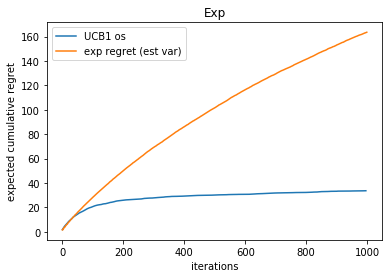

In [5]:
#plt.plot(bounds, label = 'bound')
plt.plot(expected_regrets_UCB1_os[:1000], label = 'UCB1 os')
plt.plot(saving['exp_true'][:1000], label = 'exp regret (est var)')
plt.xlabel('iterations')
plt.ylabel('expected cumulative regret')
plt.title('Exp')
plt.legend()

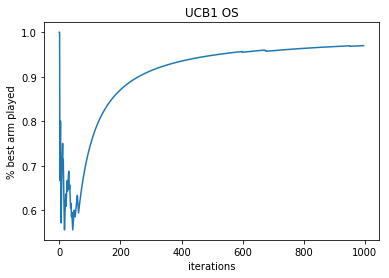

In [7]:
percent_best_arm_played = []
num_selected = 0

for i in range(len(agent.selectedActions)):
    if agent.selectedActions[i] == best_arm:
        num_selected += 1
    percent_best_arm_played.append(float(num_selected)/(i+1))
        
plt.xlabel('iterations')
plt.ylabel('% best arm played')
plt.title('UCB1 OS')
plt.plot(percent_best_arm_played)

### Test Variance Estimation 

For the experiemnts, the variannce estimation seems to be very different, where for exponential distribution, the regret for true variance and estimated variance are similar, but for normal distribution, the estimated variance gives more worse regret. So I design an experiment to show the variance estimation for both distributions. 

In [26]:
def var_estimate(rewards):
    var = np.var(rewards)

    if var == 0:
        return 1.0
    else:
        return var

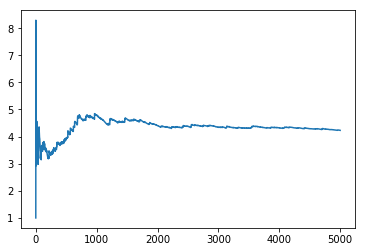

In [28]:
num_samples = 5000
samples = []
variances = []
scale = 2 

for i in range(num_samples):
    samples.append(np.random.exponential(scale = scale))
    variances.append(var_estimate(samples))
    
plt.plot(variances)

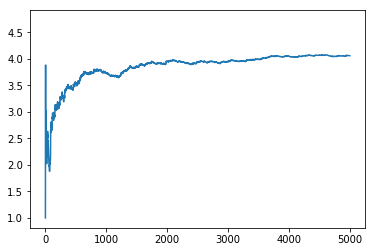

In [25]:
def var_estimate_for_folded_normal(rewards):
    var = np.var(rewards)
    mean = np.mean(rewards)

    if var == 0:
        return 1.0
    else:
        return var + mean ** 2

num_samples = 5000
samples = []
variances = []
scale = 2 

for i in range(num_samples):
    samples.append(np.abs(np.random.normal(scale = scale)))
    variances.append(var_estimate_for_folded_normal(samples))
    
plt.plot(variances)

It turns out for the absolute normal distribution, what we want is not the variance of absolte distribution, instead we want to variance of the normal distribution, which can be calculated by $\sigma^2 = \sigma_Y^2 + \mu_Y^2$, where $\mu_Y, \sigma_Y^2$ are the mean and variance of the absolute centered normal distribuiton, $\sigma^2$ is the variance of the centered normal distribution. See  https://en.wikipedia.org/wiki/Folded_normal_distribution.

So we need to re-do the experiments for ucb order statistics, and tune parameters for normal distribution as well (we already tune exp, see https://github.com/chengsoonong/eheye/blob/master/QuantUCB/ucb_os_hyperparameter_tuning_outliers_testing.ipynb). 